In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import *
from sklearn.metrics import log_loss, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn import set_config
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
import sys, os, contextlib
@contextlib.contextmanager
def suppress_output(): 
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try: 
            yield
        finally: 
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [14]:
def load_data(path):
    train = pd.read_csv(path+'Train.csv')
    test = pd.read_csv(path +'Test.csv')
    sub = pd.read_csv( path +'SampleSubmission.csv')
    id = test['id']
    return train, test, sub, id

train, test, sub, id = load_data(path="../data/")

In [15]:
for df in (train,test): 
    df.drop(columns=['id'], inplace=True)

In [16]:

isolation_forest = IsolationForest(contamination=0.1)  # Adjust contamination rate
is_inlier = isolation_forest.fit_predict(train.drop(columns=['Target']))  # Returns 1 for inliers, -1 for outliers

y_train = train['Target']
train = train[is_inlier == 1]
y_train = y_train[is_inlier == 1]

In [17]:
"""le = LabelEncoder()
y_train = le.fit_transform(y_train) """

'le = LabelEncoder()\ny_train = le.fit_transform(y_train) '

In [25]:
y_train

0        80
1        39
3        96
4        98
5        22
       ... 
2117     23
2118     26
2119     80
2121    118
2122    102
Name: Target, Length: 1910, dtype: int64

In [23]:
model = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                           depth=6,
                           class_weights=[1] * 45,  
                           random_seed=777)

skf = StratifiedKFold(n_splits=5)

def validate(trainset, testset, target_col, unique_classes):
    with suppress_output(): 
        model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
    y_predicted = model.predict_proba(testset.drop(columns=[target_col]))  
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_predicted[valid_idx]
    score = log_loss(valid_testset, valid_pred, labels=unique_classes)
    print(f"Log Loss: {score}")
    return score

unique_classes = np.sort(train['Target'].unique())  
scores = []

for train_index, test_index in skf.split(train.drop(columns='Target'), train['Target']): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    score = validate(trainset=train_v, testset=test_v, target_col='Target', unique_classes=unique_classes)
    scores.append(score)

print(f'Mean Log Loss: {np.mean(scores)}')
value  = np.array(scores).mean()

CatBoostError: Length of label=1910 and length of data=1528 is different.

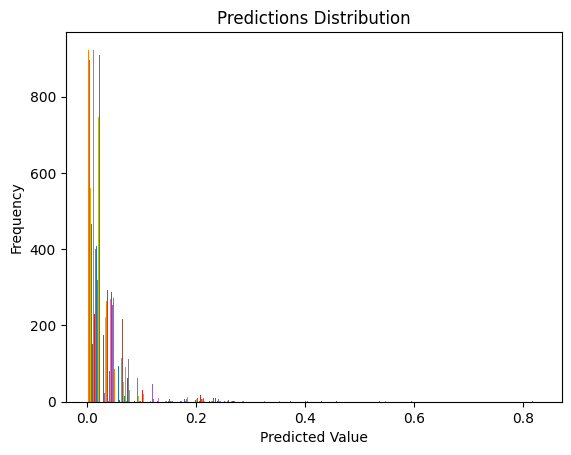

In [ ]:
import matplotlib.pyplot as plt

plt.hist(predict_proba, bins=30)
plt.title("Predictions Distribution")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

In [20]:
submission = pd.DataFrame({'id': id})
columns = [f'Target_{i}' for i in range(125)]
submission[columns] = 0.00001
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(model, method='sigmoid')  # Platt Scaling
calibrated_model.fit(train.drop(columns=['Target']), train["Target"])

y_pred_proba = calibrated_model.predict_proba(test)
y_pred_proba = np.clip(y_pred_proba, 0.00001, 0.999)
for i, class_label in enumerate(model.classes_):
    submission['Target_' + str(class_label)] = y_pred_proba[:, i]

0:	learn: 3.7469116	total: 108ms	remaining: 53.8s
1:	learn: 3.6948418	total: 210ms	remaining: 52.4s
2:	learn: 3.6489628	total: 310ms	remaining: 51.3s
3:	learn: 3.6042448	total: 437ms	remaining: 54.2s
4:	learn: 3.5604047	total: 550ms	remaining: 54.5s
5:	learn: 3.5234212	total: 681ms	remaining: 56.1s
6:	learn: 3.4854903	total: 805ms	remaining: 56.7s
7:	learn: 3.4457265	total: 928ms	remaining: 57.1s
8:	learn: 3.4121263	total: 1.03s	remaining: 56.2s
9:	learn: 3.3808669	total: 1.24s	remaining: 1m
10:	learn: 3.3527109	total: 1.34s	remaining: 59.8s
11:	learn: 3.3250053	total: 1.47s	remaining: 59.9s
12:	learn: 3.2976159	total: 1.61s	remaining: 1m
13:	learn: 3.2717242	total: 1.73s	remaining: 1m
14:	learn: 3.2455201	total: 1.9s	remaining: 1m 1s
15:	learn: 3.2204273	total: 2.04s	remaining: 1m 1s
16:	learn: 3.1972760	total: 2.3s	remaining: 1m 5s
17:	learn: 3.1728649	total: 2.5s	remaining: 1m 6s
18:	learn: 3.1527928	total: 2.71s	remaining: 1m 8s
19:	learn: 3.1296562	total: 2.93s	remaining: 1m 10s
2

In [21]:
for col in submission.columns:
    if (pd.to_numeric(submission[col], errors='coerce') > 0.0).any():
        print('hell yeah, finally no zero outputs')
    else: 
        print('not your lucky day')
        break

not your lucky day


In [22]:
submission.to_csv('submission_calibrated_3.555771454456019', index=False)